# Importing required libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import joblib
import tensorflow as tf
from wordcloud import WordCloud

In [3]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, BaggingClassifier
import warnings
warnings.simplefilter('ignore')
sns.set_theme(style="dark")

# Pre-defined functions

In [6]:
def labeled_barplot(data, feature, perc=False, n=None):

    total = len(data[feature])
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )
        else:
            label = p.get_height()

        x = p.get_x() + p.get_width() / 2
        y = p.get_height()

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )

    plt.show()


In [7]:
def stacked_barplot(data, predictor, target):
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [9]:
def checking_overfitting_undefitting(y_train, y_train_pred, y_test, y_test_pred):
    training_accuracy = accuracy_score(y_train, y_train_pred)
    testing_accuracy = accuracy_score(y_test, y_test_pred)
    if training_accuracy<=0.65:
        print("Model is underfitting.")
    elif training_accuracy>0.65 and abs(training_accuracy-testing_accuracy)>0.15:
        print("Model is overfitting.")
    else:
        print("Model is not underfitting/overfitting.")

In [10]:
def calculate_classification_metrics(y_true, y_pred, algorithm):
    accuracy = round(accuracy_score(y_true, y_pred), 3)
    precision = round(precision_score(y_true, y_pred, average='weighted'), 3)
    recall = round(recall_score(y_true, y_pred, average='weighted'), 3)
    f1 = round(f1_score(y_true, y_pred, average='weighted'), 3)
    print("Algorithm: ", algorithm)
    print()
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print()
    cm = confusion_matrix(y_true, y_pred)
    labels = ['Overcast', 'Clear','Foggy']
    plt.figure(figsize=(10, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return accuracy, precision, recall, f1

# Callback function to avoid overfitting
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.90) and (logs.get('accuracy')>0.95):
            print("\nValidation and training accuracies are high so cancelling training!")
            self.model.stop_training = True


In [11]:
#

# Data loading

In [12]:
data = pd.read_csv("weatherHistory.csv")
data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [14]:
data.describe()

,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


In [15]:
print(data["Summary"].value_counts())


Partly Cloudy                          31733
Mostly Cloudy                          28094
Overcast                               16597
Clear                                  10890
Foggy                                   7148
Breezy and Overcast                      528
Breezy and Mostly Cloudy                 516
Breezy and Partly Cloudy                 386
Dry and Partly Cloudy                     86
Windy and Partly Cloudy                   67
Light Rain                                63
Breezy                                    54
Windy and Overcast                        45
Humid and Mostly Cloudy                   40
Drizzle                                   39
Breezy and Foggy                          35
Windy and Mostly Cloudy                   35
Dry                                       34
Humid and Partly Cloudy                   17
Dry and Mostly Cloudy                     14
Rain                                      10
Windy                                      8
Humid and 

In [16]:
data = data[(data["Summary"] == "Overcast") | (data["Summary"] == "Clear") | (data["Summary"] == "Foggy")]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34635 entries, 46 to 96436
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            34635 non-null  object 
 1   Summary                   34635 non-null  object 
 2   Precip Type               34396 non-null  object 
 3   Temperature (C)           34635 non-null  float64
 4   Apparent Temperature (C)  34635 non-null  float64
 5   Humidity                  34635 non-null  float64
 6   Wind Speed (km/h)         34635 non-null  float64
 7   Wind Bearing (degrees)    34635 non-null  float64
 8   Visibility (km)           34635 non-null  float64
 9   Loud Cover                34635 non-null  float64
 10  Pressure (millibars)      34635 non-null  float64
 11  Daily Summary             34635 non-null  object 
dtypes: float64(8), object(4)
memory usage: 3.4+ MB


# Data cleaning

In [17]:
missing_values_count = data.isnull().sum()
missing_values_count

Formatted Date                0
Summary                       0
Precip Type                 239
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64

In [20]:
# Since 359 is a reasonable count. Dropping the respective rows. If the count were smaller we would've filled it up with dummy values
data.dropna(inplace=True)
# Again checking for values
missing_values_count = data.isnull().sum()
missing_values_count

Formatted Date              0
Summary                     0
Precip Type                 0
Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Loud Cover                  0
Pressure (millibars)        0
Daily Summary               0
dtype: int64

In [21]:
print("Duplicated Values: ",data.duplicated().sum())


Duplicated Values:  17


In [22]:
# Removing duplicated values
data.drop_duplicates(inplace=True)
# Again checking for duplicated values
print("Duplicated Values: ", data.duplicated().sum())

Duplicated Values:  0


In [23]:
# Rounding up the float64 data upto 2 decimals.
float_cols = data.select_dtypes(include='float')
data[float_cols.columns] = float_cols.round(2)
data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
46,2006-04-10 22:00:00.000 +0200,Overcast,rain,14.42,14.42,0.58,20.01,159.0,15.83,0.0,1007.85,Mostly cloudy throughout the day.
47,2006-04-10 23:00:00.000 +0200,Overcast,rain,14.26,14.26,0.59,16.50,168.0,14.96,0.0,1007.89,Mostly cloudy throughout the day.
48,2006-04-11 00:00:00.000 +0200,Overcast,rain,13.77,13.77,0.60,17.10,160.0,15.83,0.0,1007.36,Foggy in the evening.
49,2006-04-11 01:00:00.000 +0200,Overcast,rain,13.28,13.28,0.63,14.36,160.0,15.83,0.0,1007.26,Foggy in the evening.
50,2006-04-11 02:00:00.000 +0200,Overcast,rain,8.63,5.47,0.87,22.04,32.0,6.70,0.0,1005.10,Foggy in the evening.


# Data formatting

In [24]:
# Formatting Date Column. This can be used to identify any seasonality and trends
data['Formatted Date'] = pd.to_datetime(data['Formatted Date'], errors='coerce')
# Extracting the relevant components
data["Time"] = [d.time() for d in data['Formatted Date']]
data["Time"] = data["Time"].astype(str)
data["Time"] = data["Time"].str.split(':').str[0].astype(int)
data["Date"] = [d.date() for d in data['Formatted Date']]
data["Date"]= data["Date"].astype(str)
data["Year"] = data["Date"].str.split('-').str[0].astype(int)
data["Month"] = data["Date"].str.split('-').str[1].astype(int)
data["Day"] = data["Date"].str.split('-').str[2].astype(int)
# Dropping the original column
data = data.drop(columns=['Formatted Date','Date'], axis=1)

In [25]:
# It can be seen that the feature "Loud Cover" have only value '0' and mean and other statistical overview also support the deduction. Hence, it is the redundant column
data["Loud Cover"].value_counts()

0.0    34379
Name: Loud Cover, dtype: int64

In [26]:
# Removing 'Loud Cover'
data.drop(columns=["Loud Cover"], axis=1, inplace=True)
data.head()

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,Time,Year,Month,Day
46,Overcast,rain,14.42,14.42,0.58,20.01,159.0,15.83,1007.85,Mostly cloudy throughout the day.,22,2006,4,10
47,Overcast,rain,14.26,14.26,0.59,16.50,168.0,14.96,1007.89,Mostly cloudy throughout the day.,23,2006,4,10
48,Overcast,rain,13.77,13.77,0.60,17.10,160.0,15.83,1007.36,Foggy in the evening.,0,2006,4,11
49,Overcast,rain,13.28,13.28,0.63,14.36,160.0,15.83,1007.26,Foggy in the evening.,1,2006,4,11
50,Overcast,rain,8.63,5.47,0.87,22.04,32.0,6.70,1005.10,Foggy in the evening.,2,2006,4,11


In [27]:
# Different types of columns
numeric_columns = list(data.select_dtypes(include=['float64', 'int64']).columns)
categorical_columns = list(data.select_dtypes(include=['object']).columns)
continuous_columns = [i for i in numeric_columns if len(list(data[i].unique()))>=25]
discrete_columns = [i for i in numeric_columns if len(list(data[i].unique()))<25]
print("Numerical Columns: ", numeric_columns)
print()
print("Categorical Columns: ", categorical_columns)
print()
print("Continuous Columns: ", continuous_columns)
print()
print("Discrete Columns: ", discrete_columns)


Numerical Columns:  ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)', 'Time', 'Year', 'Month', 'Day']

Categorical Columns:  ['Summary', 'Precip Type', 'Daily Summary']

Continuous Columns:  ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)', 'Day']

Discrete Columns:  ['Time', 'Year', 'Month']


# Exploratory Data analysis


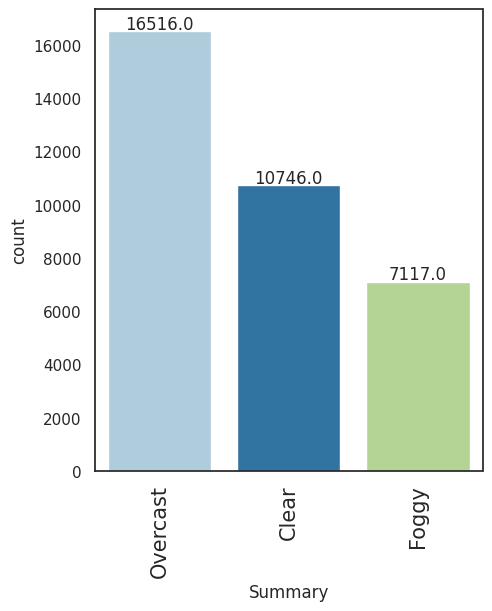

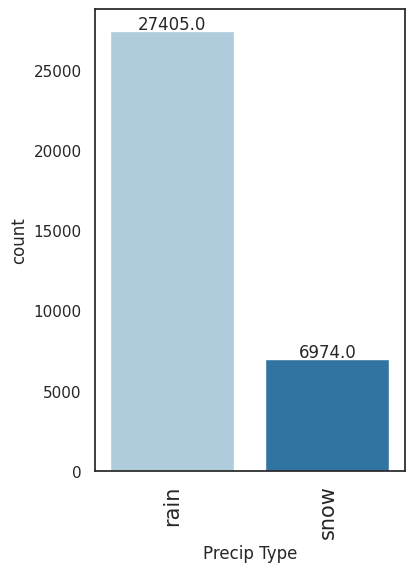

In [83]:
# Categorical columns analysis
for i in categorical_columns:
    if i in ['Daily Summary','Time']:
        pass
    else:
        labeled_barplot(data, i)

# Word cloud representation for daily summary

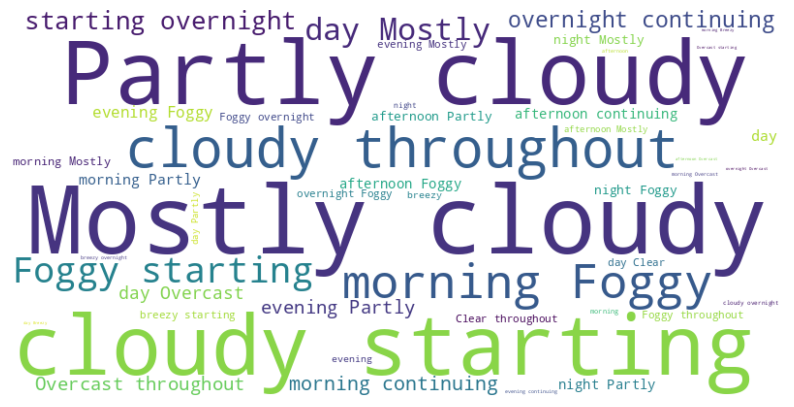

In [84]:
# Creating Word Cloud for daily summary
text = ' '.join(data['Daily Summary'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


Summary      Clear  Foggy  Overcast    All
Precip Type                               
All          10746   7117     16516  34379
rain          9354   4135     13916  27405
snow          1392   2982      2600   6974
------------------------------------------------------------------------------------------------------------------------


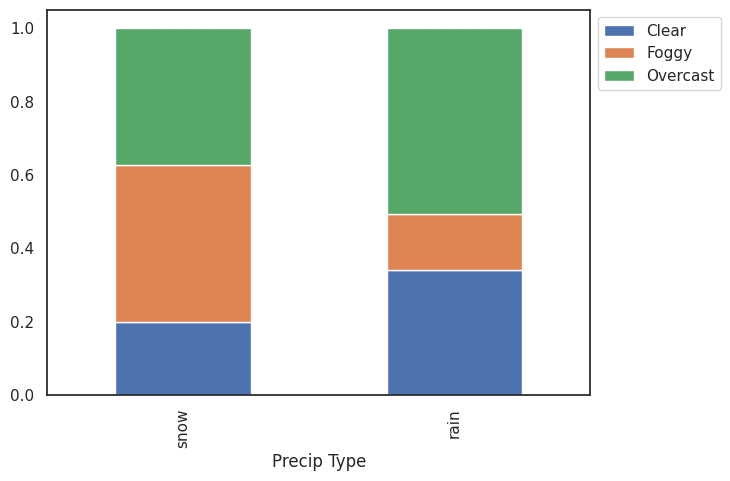

In [85]:
# Stacked barplot
stacked_barplot(data,"Precip Type" , 'Summary')

# Data Preprocessing & feature engineering

In [28]:
# Checking whether the target variable is balanced or unbalanced
counts = data["Summary"].value_counts()
total = counts.sum()
percentages = (counts / total) * 100
print(percentages)
print()
print("The classes are satifactory balanced")

Overcast    48.040955
Clear       31.257454
Foggy       20.701591
Name: Summary, dtype: float64

The classes are satifactory balanced


In [29]:
# Input features dataset
input_df = data.drop(columns="Summary", axis=1)
input_df.head()


,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Daily Summary,Time,Year,Month,Day
46,rain,14.42,14.42,0.58,20.01,159.0,15.83,1007.85,Mostly cloudy throughout the day.,22,2006,4,10
47,rain,14.26,14.26,0.59,16.50,168.0,14.96,1007.89,Mostly cloudy throughout the day.,23,2006,4,10
48,rain,13.77,13.77,0.60,17.10,160.0,15.83,1007.36,Foggy in the evening.,0,2006,4,11
49,rain,13.28,13.28,0.63,14.36,160.0,15.83,1007.26,Foggy in the evening.,1,2006,4,11
50,rain,8.63,5.47,0.87,22.04,32.0,6.70,1005.10,Foggy in the evening.,2,2006,4,11


In [30]:
# Target variable
# Applying mapping
encoder = LabelEncoder()
y = data["Summary"]
y = encoder.fit_transform(y)

# Checking the mapping of the classes
class_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
for class_label, class_number in class_mapping.items():
    print(f"Class '{class_label}' is labeled as {class_number}")

Class 'Clear' is labeled as 0
Class 'Foggy' is labeled as 1
Class 'Overcast' is labeled as 2


In [31]:
# As "Precip Type" have only 2 values, hence applying binary encoding
mapping = {'rain': 0, 'snow': 1}
input_df['Precip Type'] = input_df['Precip Type'].map(mapping)

In [32]:
# As "Daily Summary" have 221 unique values, hence applying Frequency encoding
# Creating a new column for frequency encoding and removing previous column
input_df['Daily Summary Frequency'] = input_df['Daily Summary'].map(input_df['Daily Summary'].value_counts(normalize=True))
input_df.drop(columns=['Daily Summary'], axis=1, inplace=True)
# Checking data
input_df.head()

,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Time,Year,Month,Day,Daily Summary Frequency
46,0,14.42,14.42,0.58,20.01,159.0,15.83,1007.85,22,2006,4,10,0.168068
47,0,14.26,14.26,0.59,16.50,168.0,14.96,1007.89,23,2006,4,10,0.168068
48,0,13.77,13.77,0.60,17.10,160.0,15.83,1007.36,0,2006,4,11,0.004247
49,0,13.28,13.28,0.63,14.36,160.0,15.83,1007.26,1,2006,4,11,0.004247
50,0,8.63,5.47,0.87,22.04,32.0,6.70,1005.10,2,2006,4,11,0.004247


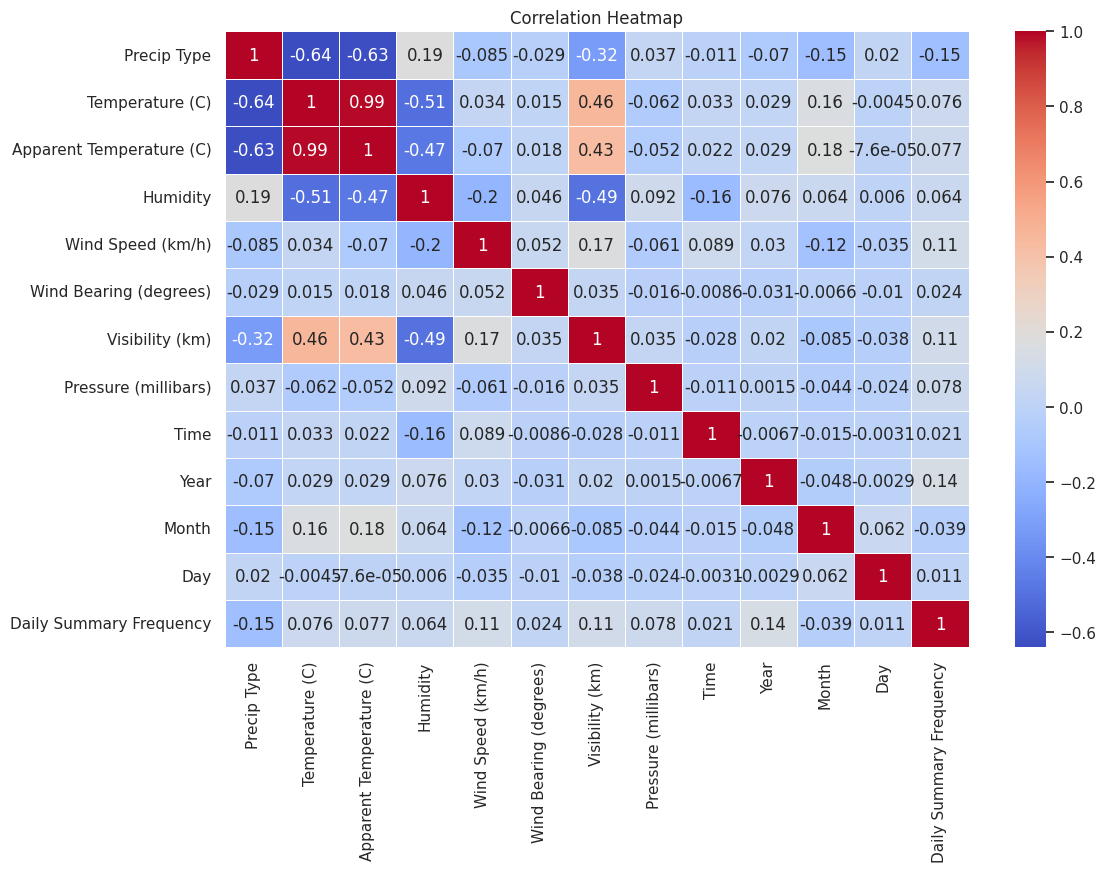

In [33]:
# Confirming multicollinearity using heatmap
sns.set(style="white")
plt.figure(figsize=(12,8))
sns.heatmap(input_df.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [34]:
# As Daily Summary Frequency has a negligible correlation with the other features and it is apparent that the final target is not going to be affected by this, removing it.
input_df.drop(['Daily Summary Frequency'], axis=1, inplace=True)

In [35]:

# As VIF of Temperature (C) is the highest and Temperature is highly correlated with Apparent Temperature, removing it
input_df.drop(['Temperature (C)'], axis=1, inplace=True)

In [36]:
# Creating X input set
X = input_df.values


In [50]:
# Splitting the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [51]:
# Apply scaling on the input_df DataFrame
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

# Building model

## 1. Logistic Regression Classifier

In [38]:
# Hyperparameter tuning
parameters = {'solver': ['liblinear', 'saga'],
              'multi_class':['ovr', 'multinomial'],
              'C':[0.001, 0.01, 10.0],
              'penalty': ['l1', 'l2']}
# Model Creation and Training
model_lr = LogisticRegression(n_jobs=-1)
models_lr = GridSearchCV(estimator=model_lr, param_grid=parameters, cv=4)
models_lr.fit(x_train, y_train)
best_parameters = models_lr.best_params_
print("Best Hyperparameters:", best_parameters)
print()
# Predictions for train
best_model_lr = models_lr.best_estimator_
y_pred_lr = best_model_lr.predict(x_train)
# Predictions for test
y_pred_lr_new = best_model_lr.predict(x_test)
checking_overfitting_undefitting(y_train, y_pred_lr, y_test, y_pred_lr_new)

Best Hyperparameters: {'C': 10.0, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga'}

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  Logistic Regression

Accuracy: 0.805
Precision: 0.802
Recall: 0.805
F1 Score: 0.802



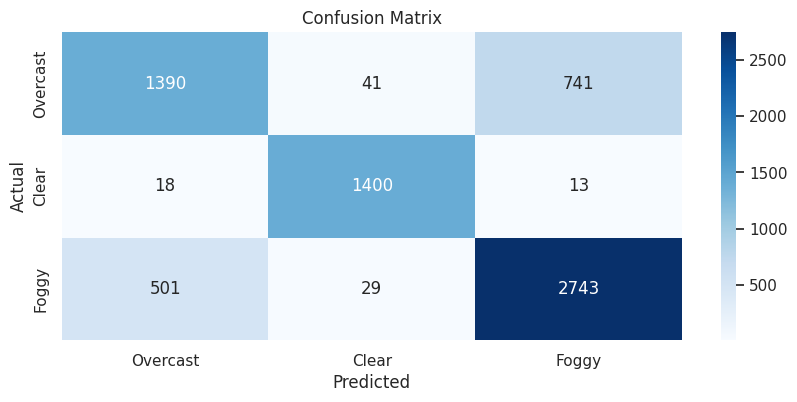

In [39]:
# Evaluation Metrics Calculation
print("Testing Performance")
accuracy_lr, precision_lr, recall_lr, f1_lr = calculate_classification_metrics(y_test, y_pred_lr_new, "Logistic Regression")

## 2. Gaussian Naive Bayes Classifier

In [40]:
# Hyperparameter tuning
parameters = {'var_smoothing':[1e-9, 1e-8, 1e-10]}
# Model Creation and Training
model_nb = GaussianNB()
models_nb = GridSearchCV(estimator=model_nb, param_grid=parameters, cv=4)
models_nb.fit(x_train, y_train)
best_parameters = models_nb.best_params_
print("Best Hyperparameters:", best_parameters)
print()
# Predictions on training data
best_model_nb = models_nb.best_estimator_
y_pred_nb = best_model_nb.predict(x_train)
# Predictions on test data
y_pred_nb_new = best_model_nb.predict(x_test)
checking_overfitting_undefitting(y_train, y_pred_nb, y_test, y_pred_nb_new)


Best Hyperparameters: {'var_smoothing': 1e-09}

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  Gaussian NB

Accuracy: 0.756
Precision: 0.763
Recall: 0.756
F1 Score: 0.741



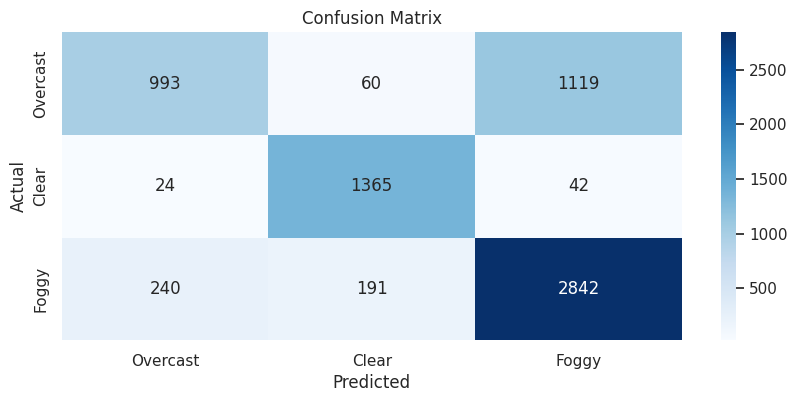

In [41]:
# Evaluation Metrics Calculation
print("Testing Performance")
accuracy_nb, precision_nb, recall_nb, f1_nb = calculate_classification_metrics(y_test, y_pred_nb_new, "Gaussian NB")


## 3. Support Vector Machine Classifier

In [42]:
# Hyperparameter tuning
parameters = {'loss':['log_loss','perceptron','hinge','squared_epsilon_insensitive'],
              'penalty': ['l1', 'l2'],
              'alpha':[0.001,0.01,0.0001],
              'learning_rate':['optimal','adaptive','invscaling']}
# Model Creation and Training
model_svc = SGDClassifier()
models_svc = GridSearchCV(estimator=model_svc, param_grid=parameters, cv=4)
models_svc.fit(x_train, y_train)
best_parameters = models_svc.best_params_
print("Best Hyperparameters:", best_parameters)
print()
# Predictions on train data
best_model_svc = models_svc.best_estimator_
y_pred_svc = best_model_svc.predict(x_train)
# Predictions on test data
y_pred_svc_new = best_model_svc.predict(x_test)
checking_overfitting_undefitting(y_train, y_pred_svc, y_test, y_pred_svc_new)

Best Hyperparameters: {'alpha': 0.001, 'learning_rate': 'optimal', 'loss': 'log_loss', 'penalty': 'l1'}

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  SVC

Accuracy: 0.796
Precision: 0.793
Recall: 0.796
F1 Score: 0.793



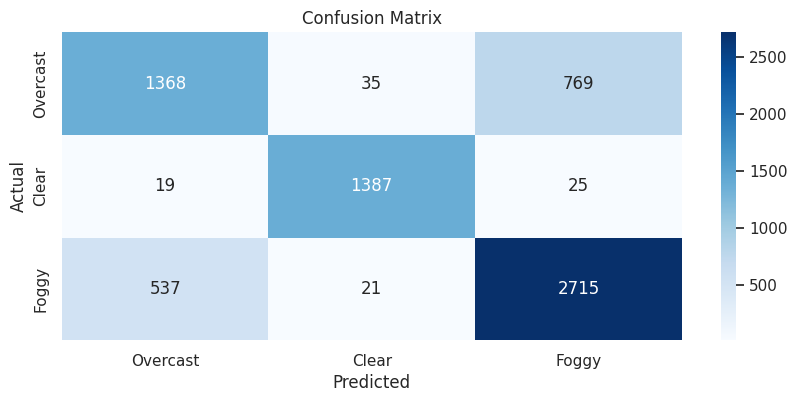

In [43]:
# Evaluation Metrics Calculation
print("Testing Performance")
accuracy_svc, precision_svc, recall_svc, f1_svc = calculate_classification_metrics(y_test, y_pred_svc_new, "SVC")

## 4. SGD classifier

In [44]:
# Hyperparameter tuning
parameters = {'loss':['log_loss','perceptron','hinge','squared_epsilon_insensitive'],
              'penalty': ['l1', 'l2'],
              'alpha':[0.001,0.01,0.0001],
              'learning_rate':['optimal','adaptive','invscaling']}
# Model Creation and Training
model_sgd = SGDClassifier()
models_sgd = GridSearchCV(estimator=model_sgd, param_grid=parameters, cv=4)
models_sgd.fit(x_train, y_train)
best_parameters = models_sgd.best_params_
print("Best Hyperparameters:", best_parameters)
print()
# Predictions on train data
best_model_sgd = models_sgd.best_estimator_
y_pred_sgd = best_model_sgd.predict(x_train)
# Predictions on test data
y_pred_sgd_new = best_model_sgd.predict(x_test)
checking_overfitting_undefitting(y_train, y_pred_sgd, y_test, y_pred_sgd_new)


Best Hyperparameters: {'alpha': 0.001, 'learning_rate': 'optimal', 'loss': 'log_loss', 'penalty': 'l1'}

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  SGD Classifier

Accuracy: 0.795
Precision: 0.793
Recall: 0.795
F1 Score: 0.793



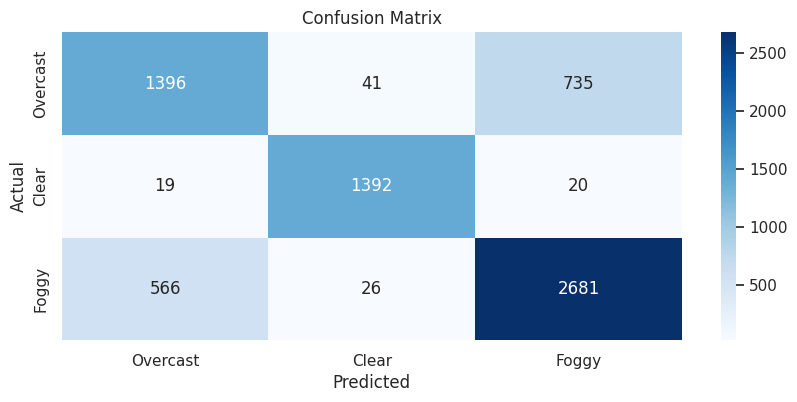

In [45]:
# Evaluation Metrics Calculation
print("Testing Performance")
accuracy_sgd, precision_sgd, recall_sgd, f1_sgd = calculate_classification_metrics(y_test, y_pred_sgd_new, "SGD Classifier")

## 5. Decision Tree Classifier

In [46]:
# Hyperparameter tuning
parameters = {'criterion':['gini', 'entropy', 'log_loss'],
              'max_depth': [None, 5, 10],
              'min_samples_split': [None, 2, 5],
              'splitter':['best','random']}
# Model Creation and Training
model_dt = DecisionTreeClassifier()
models_dt = GridSearchCV(estimator=model_dt, param_grid=parameters, cv=4)
models_dt.fit(x_train, y_train)
best_parameters = models_dt.best_params_
print("Best Hyperparameters:", best_parameters)
print()
# Predictions on train data
best_model_dt = models_dt.best_estimator_
y_pred_dt = best_model_dt.predict(x_train)
# Predictions on test data
y_pred_dt_new = best_model_dt.predict(x_test)
checking_overfitting_undefitting(y_train, y_pred_dt, y_test, y_pred_dt_new)

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2, 'splitter': 'best'}

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  Decision Tree

Accuracy: 0.895
Precision: 0.894
Recall: 0.895
F1 Score: 0.894



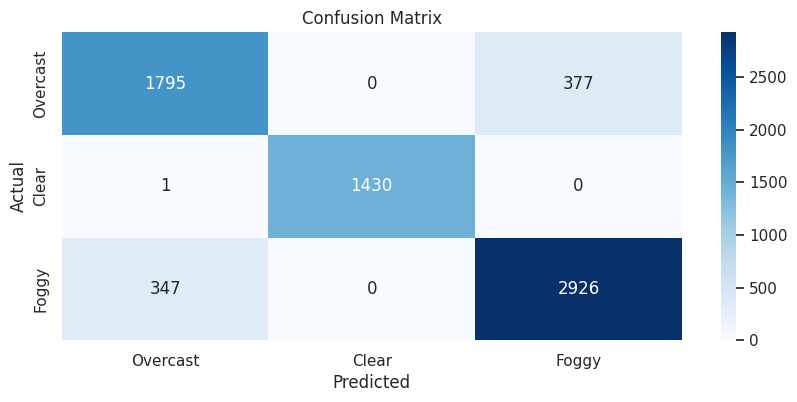

In [47]:
# Evaluation Metrics Calculation
print("Testing Performance")
accuracy_dt, precision_dt, recall_dt, f1_dt = calculate_classification_metrics(y_test, y_pred_dt_new, "Decision Tree")

## 6. KNN Classifier

In [48]:
# Hyperparameter tuning
parameters = {'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree','kd_tree','brute'],
            'p': [1,2]}
# Model Creation and Training
model_knn = KNeighborsClassifier(n_neighbors=5)
models_knn = GridSearchCV(estimator=model_knn, param_grid=parameters, cv=4)
models_knn.fit(x_train, y_train)
best_parameters = models_knn.best_params_
print("Best Hyperparameters:", best_parameters)
print()
# Predictions on train data
best_model_knn = models_knn.best_estimator_
y_pred_knn = best_model_knn.predict(x_train)
# Predictions on test data
y_pred_knn_new = best_model_knn.predict(x_test)
checking_overfitting_undefitting(y_train, y_pred_knn, y_test, y_pred_knn_new)

Best Hyperparameters: {'algorithm': 'auto', 'p': 1, 'weights': 'distance'}

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  KNN

Accuracy: 0.898
Precision: 0.898
Recall: 0.898
F1 Score: 0.898



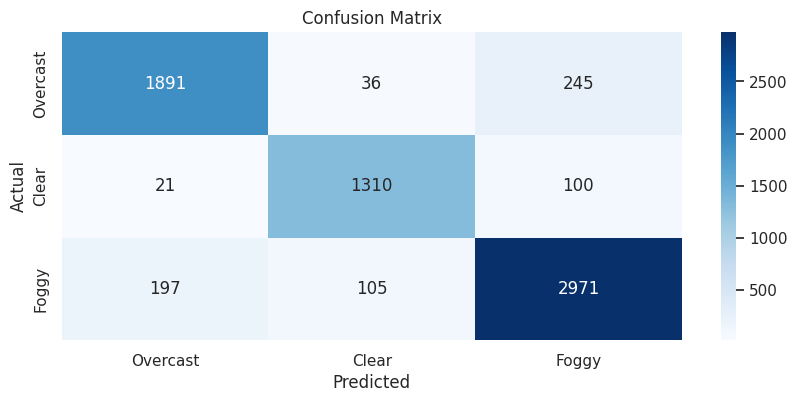

In [49]:
# Evaluation Metrics Calculation
print("Testing Performance")
accuracy_knn, precision_knn, recall_knn, f1_knn = calculate_classification_metrics(y_test, y_pred_knn_new, "KNN")

## 7. Random Forest Classifier

In [50]:
# Hyperparameter tuning
parameters = {'max_depth': [None, 5],
            'class_weight': [None, 'balanced'],
            'min_samples_split': [None, 2, 5]}
# Model Creation and Training
model_rf = RandomForestClassifier()
models_rf = GridSearchCV(estimator=model_rf, param_grid=parameters, cv=4)
models_rf.fit(x_train, y_train)
best_parameters = models_rf.best_params_
print("Best Hyperparameters:", best_parameters)
print()
# Predictions on train data
best_model_rf = models_rf.best_estimator_
y_pred_rf = best_model_rf.predict(x_train)
# Predictions on test data
y_pred_rf_new = best_model_rf.predict(x_test)
checking_overfitting_undefitting(y_train, y_pred_rf, y_test, y_pred_rf_new)

Best Hyperparameters: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2}

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  Random Forest

Accuracy: 0.938
Precision: 0.939
Recall: 0.938
F1 Score: 0.938



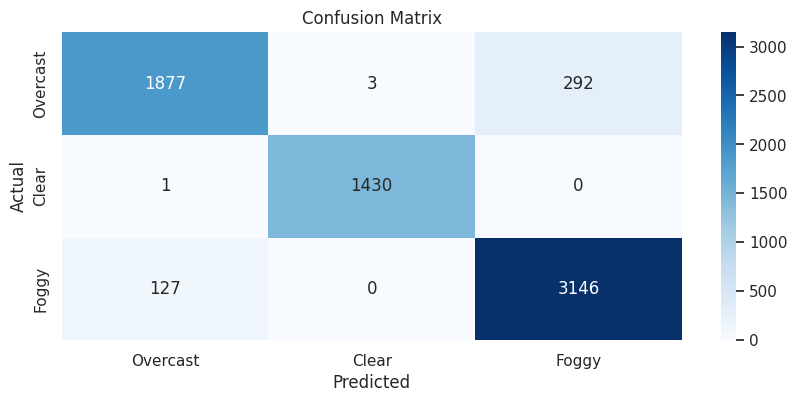

In [51]:
# Evaluation Metrics Calculation
print("Testing Performance")
accuracy_rf, precision_rf, recall_rf, f1_rf = calculate_classification_metrics(y_test, y_pred_rf_new, "Random Forest")

## 8. Extra Trees classifier

In [52]:
# Hyperparameter tuning
parameters = {'max_depth': [None, 5],
            'class_weight': [None, 'balanced'],
            'min_samples_split': [None, 2, 5],
            'criterion':['gini','log_loss','entropy']}
# Model Creation and Training
model_et = ExtraTreesClassifier()
models_et = GridSearchCV(estimator=model_et, param_grid=parameters, cv=4)
models_et.fit(x_train, y_train)
best_parameters = models_et.best_params_
print("Best Hyperparameters:", best_parameters)
print()
# Predictions on train data
best_model_et = models_et.best_estimator_
y_pred_et = best_model_et.predict(x_train)
# Predictions on test data
y_pred_et_new = best_model_et.predict(x_test)
checking_overfitting_undefitting(y_train, y_pred_et, y_test, y_pred_et_new)

Best Hyperparameters: {'class_weight': None, 'criterion': 'log_loss', 'max_depth': None, 'min_samples_split': 2}

Model is not underfitting/overfitting.


Testing Performance
Algorithm:  Extra Trees

Accuracy: 0.946
Precision: 0.946
Recall: 0.946
F1 Score: 0.945



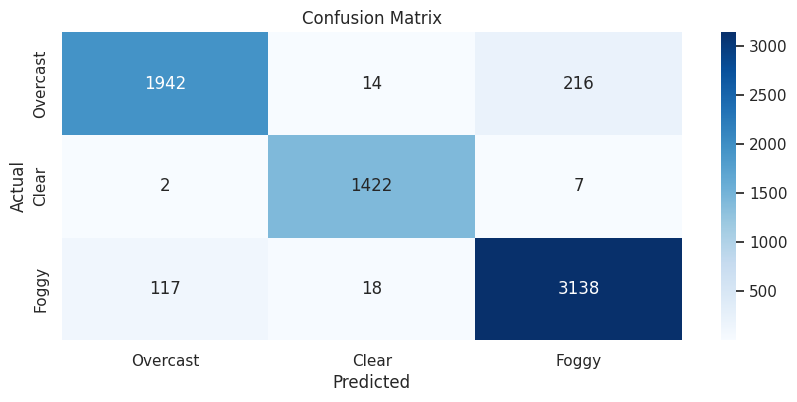

In [53]:
# Evaluation Metrics Calculation
print("Testing Performance")
accuracy_et, precision_et, recall_et, f1_et = calculate_classification_metrics(y_test, y_pred_et_new, "Extra Trees")

# Comparison and analysis

In [54]:
# Results
print("Testing Performances for Machine Learning Algorithms")
result = pd.DataFrame({"Algorithms":['Logistic Regression', "Gaussian Naive Bayes", "SVC", "SGD Classifier", "Decision Tree", "KNN","Random Forest", "Extra Trees Classifier"],
                       "Accuracy":[accuracy_lr, accuracy_nb, accuracy_svc, accuracy_sgd, accuracy_dt, accuracy_knn, accuracy_rf, accuracy_et],
                       "Precision":[precision_lr, precision_nb, precision_svc, precision_sgd, precision_dt, precision_knn, precision_rf, precision_et],
                       "Recall":[recall_lr, recall_nb, recall_svc, recall_sgd, recall_dt, recall_knn, recall_rf, recall_et],
                       "F1 Score":[f1_lr, f1_nb, f1_svc, f1_sgd, f1_dt, f1_knn, f1_rf, f1_et]}).set_index('Algorithms')
result

Testing Performances for Machine Learning Algorithms


,Accuracy,Precision,Recall,F1 Score
Algorithms,,,,
Logistic Regression,0.805,0.802,0.805,0.802
Gaussian Naive Bayes,0.756,0.763,0.756,0.741
SVC,0.796,0.793,0.796,0.793
SGD Classifier,0.795,0.793,0.795,0.793
Decision Tree,0.895,0.894,0.895,0.894
KNN,0.898,0.898,0.898,0.898
Random Forest,0.938,0.939,0.938,0.938
Extra Trees Classifier,0.946,0.946,0.946,0.945


# Deeplearning Models (Neural Newtworks)

## 1. LSTM

In [64]:
from sklearn.preprocessing import MinMaxScaler

In [65]:
scaler2 = MinMaxScaler()
input2=input_df
input2 = scaler2.fit_transform(input2)

In [66]:
input2


array([[0.        , 0.63482977, 0.58      , ..., 0.        , 0.27272727,
        0.3       ],
       [0.        , 0.6324194 , 0.59      , ..., 0.        , 0.27272727,
        0.3       ],
       [0.        , 0.62503766, 0.6       , ..., 0.        , 0.27272727,
        0.33333333],
       ...,
       [0.        , 0.64386864, 0.9       , ..., 1.        , 0.72727273,
        0.26666667],
       [0.        , 0.62654414, 0.93      , ..., 1.        , 0.72727273,
        0.26666667],
       [0.        , 0.65968665, 0.88      , ..., 1.        , 0.72727273,
        0.26666667]])

In [67]:
n = len(input2)
train_df = input2[0:int(n*0.7)]
val_df = input2[int(n*0.7):int(n*0.9)]
test_df = input2[int(n*0.9):]

n_feature = input2.shape[1]

In [68]:
n_feature

11

In [69]:
def timestep_split(data, n_step):
    x, y = [], []

    length = len(data)
    for i in range(n_step, length):
        x.append(data[i-n_step:i])
        y.append(data[i])

    return np.array(x), np.array(y)

In [70]:
n_timestep = 15
n_timepred = 1

In [71]:
x_train2, y_train2 = timestep_split(data=train_df, n_step=n_timestep)
x_val2, y_val2 = timestep_split(data=val_df, n_step=n_timestep)
x_test2, y_test2 = timestep_split(data=test_df, n_step=n_timestep)

In [72]:
x_train2[0], y_train2[0]

(array([[0.        , 0.63482977, 0.58      , 0.61006098, 0.44289694,
         0.98322981, 0.96317781, 0.95652174, 0.        , 0.27272727,
         0.3       ],
        [0.        , 0.6324194 , 0.59      , 0.50304878, 0.46796657,
         0.92919255, 0.96321604, 1.        , 0.        , 0.27272727,
         0.3       ],
        [0.        , 0.62503766, 0.6       , 0.52134146, 0.44568245,
         0.98322981, 0.96270953, 0.        , 0.        , 0.27272727,
         0.33333333],
        [0.        , 0.61765592, 0.63      , 0.43780488, 0.44568245,
         0.98322981, 0.96261396, 0.04347826, 0.        , 0.27272727,
         0.33333333],
        [0.        , 0.5       , 0.87      , 0.67195122, 0.08913649,
         0.41614907, 0.9605497 , 0.08695652, 0.        , 0.27272727,
         0.33333333],
        [0.        , 0.58707442, 0.83      , 0.34542683, 0.42339833,
         0.98322981, 0.96237505, 0.13043478, 0.        , 0.27272727,
         0.33333333],
        [0.        , 0.58601989, 0.89   

In [73]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

In [74]:
model = keras.models.Sequential()

model.add(Input(shape=(n_timestep,n_feature), name='Input'))

model.add(LSTM(units=64,
               activation='tanh',
               recurrent_activation='sigmoid',
               use_bias=True,
               kernel_initializer='glorot_uniform',
               recurrent_initializer='orthogonal',
               bias_initializer='zeros',
               dropout=0.0,
               recurrent_dropout=0.0,
               return_sequences=True,
               name='LSTM_many_to_many'))

model.add(LSTM(units=64,
               activation='tanh',
               recurrent_activation='sigmoid',
               use_bias=True,
               kernel_initializer='glorot_uniform',
               recurrent_initializer='orthogonal',
               bias_initializer='zeros',
               dropout=0.0,
               recurrent_dropout=0.0,
               name='LSTM_many_to_one'))

model.add(Dense(units=n_feature,
                activation='sigmoid',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                name='Output_layer'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001,
                               beta_1=0.9,
                               beta_2=0.999,
                               epsilon=1e-08)

model.compile(optimizer=opt, loss='mse')

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_many_to_many (LSTM)    (None, 15, 64)            19456     
                                                                 
 LSTM_many_to_one (LSTM)     (None, 64)                33024     
                                                                 
 Output_layer (Dense)        (None, 11)                715       
                                                                 
Total params: 53,195
Trainable params: 53,195
Non-trainable params: 0
_________________________________________________________________


In [75]:
path = '/kaggle/working/LSTM_model_15timesteps.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath=path, monitor='val_loss', save_best_only=True)

In [76]:
history0=model.fit(x_train2, y_train2, epochs=5, verbose=0, callbacks=[checkpoint], batch_size=256,validation_data=(x_val2, y_val2), validation_batch_size=256)

In [77]:
#load best model
model = keras.models.load_model('/kaggle/working/LSTM_model_15timesteps.h5')

In [78]:
y_predict = model.predict(x_test2)

y_predict_inverse = scaler2.inverse_transform(y_predict)
y_test_inverse = scaler2.inverse_transform(y_test2)

107/107 [==============================] - 3s 11ms/step


In [79]:
rain = y_predict_inverse[:,0] < 0.5
snow = y_predict_inverse[:,0] >= 0.5
y_predict_inverse[rain,0] = 0
y_predict_inverse[snow,0] = 1

In [80]:
BA = keras.metrics.BinaryAccuracy(threshold=0.5)
BA.update_state(y_test_inverse[:,0], y_predict_inverse[:,0])
R_Accuracy = float(BA.result())
print('Accuracy: {:.2f}%'.format(R_Accuracy*100))

Accuracy: 97.87%


In [81]:
# Print the final training loss
final_loss = history0.history['loss'][-1]
print(f'Final Training Loss: {final_loss}')

Final Training Loss: 0.024544427171349525


## 2. Feed Forward Neural Network

In [53]:
# Converting labels to one-hot encoded format
y_train_encoded = tf.keras.utils.to_categorical(y_train, 3)
y_test_encoded = tf.keras.utils.to_categorical(y_test, 3)

In [54]:
# Reshaping input data for RNN
x_train_reshaped = np.expand_dims(x_train, axis=2)
x_test_reshaped = np.expand_dims(x_test, axis=2)

In [57]:
x_train.shape[1]

11

Epoch 1/150
430/430 [==============================] - 3s 4ms/step - loss: 0.5219 - accuracy: 0.7642 - val_loss: 0.4298 - val_accuracy: 0.8067
Epoch 2/150
430/430 [==============================] - 2s 4ms/step - loss: 0.4059 - accuracy: 0.8161 - val_loss: 0.3987 - val_accuracy: 0.8217
Epoch 3/150
430/430 [==============================] - 1s 3ms/step - loss: 0.3758 - accuracy: 0.8321 - val_loss: 0.3690 - val_accuracy: 0.8367
Epoch 4/150
430/430 [==============================] - 1s 3ms/step - loss: 0.3536 - accuracy: 0.8445 - val_loss: 0.3537 - val_accuracy: 0.8450
Epoch 5/150
430/430 [==============================] - 2s 4ms/step - loss: 0.3377 - accuracy: 0.8533 - val_loss: 0.3443 - val_accuracy: 0.8505
Epoch 6/150
430/430 [==============================] - 2s 5ms/step - loss: 0.3247 - accuracy: 0.8595 - val_loss: 0.3325 - val_accuracy: 0.8544
Epoch 7/150
430/430 [==============================] - 2s 5ms/step - loss: 0.3127 - accuracy: 0.8640 - val_loss: 0.3295 - val_accuracy: 0.8567

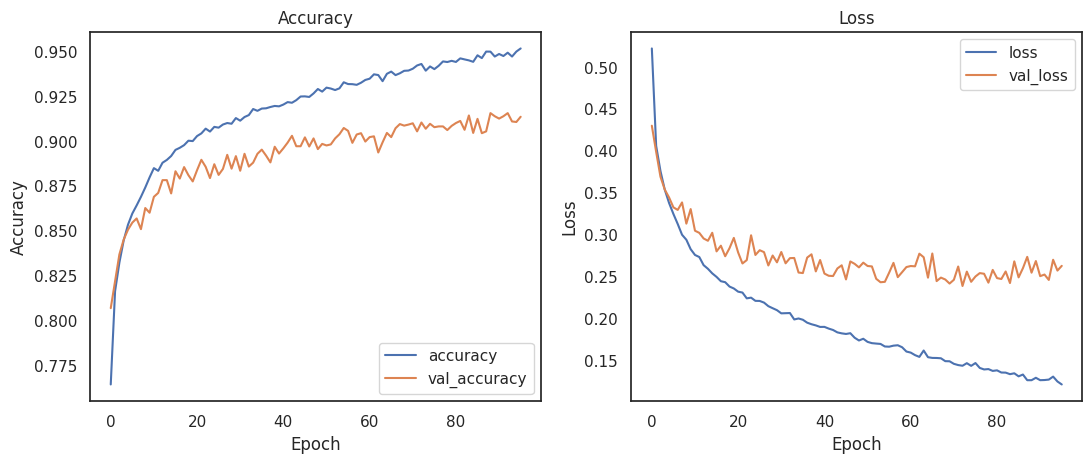

In [60]:
# Architecture 1: 64-64-128-3 Feed Forward Neural Network
# Defining the ANN architecture
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, activation='relu', input_dim=11))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(3, activation='softmax'))
# Model Compilation
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Stopping early to avoid overfitting
stop_callback = myCallback()

# Training
history = model.fit(x_train, y_train_encoded, epochs=150, batch_size=64, validation_data=(x_test, y_test_encoded), callbacks=[stop_callback])

# Plotting training and testing curves
default_size = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=[default_size[0] * 2, default_size[1]])

fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label = 'accuracy')          # Train accuracy (blue)
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')  # Valid accuracy (orange)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')          # Train loss (blue)
plt.plot(history.history['val_loss'], label='val_loss')  # Valid loss (orange)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()

In [61]:
# Evaluating the model on test data
test_loss_0, test_accuracy_0 = model.evaluate(x_test, y_test_encoded, verbose=0)
print('Test Loss:', test_loss_0)
print('Test Accuracy:', test_accuracy_0)


Test Loss: 0.2628285884857178
Test Accuracy: 0.9134671092033386


# 3. Recurrent Neural Network

Epoch 1/150
430/430 [==============================] - 5s 8ms/step - loss: 0.6226 - accuracy: 0.7061 - val_loss: 0.4505 - val_accuracy: 0.7978
Epoch 2/150
430/430 [==============================] - 3s 7ms/step - loss: 0.4321 - accuracy: 0.8061 - val_loss: 0.4431 - val_accuracy: 0.7946
Epoch 3/150
430/430 [==============================] - 4s 9ms/step - loss: 0.4113 - accuracy: 0.8174 - val_loss: 0.4013 - val_accuracy: 0.8165
Epoch 4/150
430/430 [==============================] - 4s 9ms/step - loss: 0.3938 - accuracy: 0.8221 - val_loss: 0.4487 - val_accuracy: 0.8086
Epoch 5/150
430/430 [==============================] - 3s 7ms/step - loss: 0.3804 - accuracy: 0.8292 - val_loss: 0.3921 - val_accuracy: 0.8220
Epoch 6/150
430/430 [==============================] - 3s 7ms/step - loss: 0.3678 - accuracy: 0.8375 - val_loss: 0.3858 - val_accuracy: 0.8290
Epoch 7/150
430/430 [==============================] - 4s 8ms/step - loss: 0.3609 - accuracy: 0.8392 - val_loss: 0.3775 - val_accuracy: 0.8301

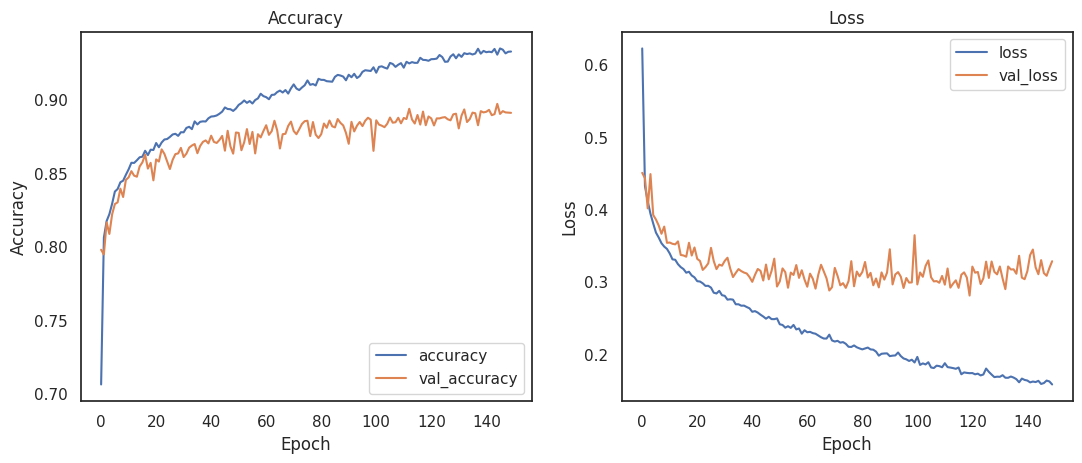

In [62]:
# Architecture 1: 32-64-128-3 RNN with 'relu' and 'softmax'
# Defining the RNN architecture
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.SimpleRNN(32, activation='relu', input_shape=(11, 1)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(3, activation='softmax'))

# Model Compilation
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Stopping early to avoid overfitting
stop_callback = myCallback()
# Training
history = model.fit(x_train_reshaped, y_train_encoded, epochs=150, batch_size=64, validation_data=(x_test_reshaped, y_test_encoded), callbacks=[stop_callback])

# Plotting training and testing curves
default_size = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=[default_size[0] * 2, default_size[1]])

fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label = 'accuracy')          # Train accuracy (blue)
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')  # Valid accuracy (orange)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')          # Train loss (blue)
plt.plot(history.history['val_loss'], label='val_loss')  # Valid loss (orange)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()

In [63]:
# Evaluating the model on test data
test_loss_3, test_accuracy_3 = model.evaluate(x_test_reshaped, y_test_encoded, verbose=0)
print('Test Loss:', test_loss_3)
print('Test Accuracy:', test_accuracy_3)

Test Loss: 0.32816365361213684
Test Accuracy: 0.8910703659057617


# Analysis b/w the neural networks

In [82]:
# Results
print("Testing Performances for Deep Learning Algorithms on 150 Epochs")
result = pd.DataFrame({"Algorithms":['LSTM Model', "Feed Forward Neural Network",  "Recurrent Neural Network"],
                       "Activation Functions":["tanh and sigmoid", "relu","relu"],
                       "Optimizers":["Adam","Adam","Adam"],
                       "Accuracy":[round(R_Accuracy,3),round(test_accuracy_0,3), round(test_accuracy_3,3)],
                       "Loss":[round(final_loss,3),round(test_loss_0,3), round(test_loss_3,3)]}).set_index('Algorithms')
result

Testing Performances for Deep Learning Algorithms on 150 Epochs


,Activation Functions,Optimizers,Accuracy,Loss
Algorithms,,,,
LSTM Model,tanh and sigmoid,Adam,0.979,0.025
Feed Forward Neural Network,relu,Adam,0.913,0.263
Recurrent Neural Network,relu,Adam,0.891,0.328
